In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [14]:
#sympt dist params
ts_alpha = 4.84**2/2.8**2
ts_beta = 4.84/2.8**2

def H(t):
    if isinstance(t,np.ndarray):
        ans = np.zeros(len(t))
        ans[t>0] = 1
        return ans
    else:
        if t >= 0:
            return 1
        else:
            return 0

def I(t,t0,x,y):
    return (H(t-(t0+x)) - H(t-(t0+y)))

def J(t,x,y,a,b):
    if b > a:
        ans = (t-(a+x))*H(t-(a+x)) - (t-(a+y))*H(t-(a+y)) +\
              (t-(b+y))*H(t-(b+y)) - (t-(b+x))*H(t-(b+x))
    else:
        if isinstance(t,np.ndarray):
            ans = np.zeros(len(t))
        else:
            ans = 0
        
    return ans

def K(xt,yt,c,d): 
    ans = (d-xt)*H(d-xt) - (d-yt)*H(d-yt) +\
          (c-yt)*H(c-yt) - (c-xt)*H(c-xt)
    return ans

def L(xt,yt,c,d):
    ans = 0.5*((d**2 - xt**2)*H(d-xt) - (d**2 - yt**2)*H(d-yt) +\
               (c**2 - yt**2)*H(c-yt) - (c**2 - xt**2)*H(c-xt))
    return ans
    
def M(x,y,a,b,c,d):
    ans = L(x+a,x+b,c,d) - L(y+a,y+b,c,d) +\
      (x+a)*(c - (a+x))*H(c-(a+x)) -\
      (x+b)*(c - (b+x))*H(c-(b+x)) -\
      (y+a)*(c - (a+y))*H(c-(a+y)) +\
      (y+b)*(c - (b+y))*H(c-(b+y)) -\
      (x+a)*(d - (a+x))*H(d-(a+x)) +\
      (x+b)*(d - (b+x))*H(d-(b+x)) +\
      (y+a)*(d - (a+y))*H(d-(a+y)) -\
      (y+b)*(d - (b+y))*H(d-(b+y))
    
    return ans

def f(t,t0,tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol):
    t2 = ts - taud
    t3 = tp + taup
    tau1 = t2 - tp
    tau2 = t3 - t2 
    ans = 1
    if tau1 > 0:
        k1 = np.floor(tau1/tauf)
        for k in np.arange(k1):
            ans -= sens*((1-sens)**k)*I(t,t0,k*tauf+taud,k*tauf+taud+tauisol)
        k = k1
        H1 = H(t0 - (np.min(np.array([t2,t3])) - k*tauf))
        ans -= (1-H1)*sens*((1-sens)**k)*I(t,t0,k*tauf+taud,k*tauf+taud+tauisol)
        ans -= Psisol*((1 - sens)**k)*(H1 + (1-H1)*(1-sens))*I(t,0,ts,ts+tauisol)
        if tau2 > 0:
            k2 = np.floor(tau2/tauf)
            k3 = np.max([np.floor(taup/tauf - (k1+1)),0])
            for k in np.arange(k1,k1+k2):
                ans -= (1-Psisol)*H1*sens*((1-sens)**k)*I(t,t0,k*tauf+taud,k*tauf+taud+tauisol)
            k = k1 + k2
            H2 = H(t0 - (t3 - k*tauf))
            ans -= (1-Psisol)*H1*(1-H2)*sens*((1-sens)**k)*I(t,t0,k*tauf+taud,k*tauf+taud+tauisol)
            for k in np.arange(k1+1,k1+k3+1):
                ans -= (1-Psisol)*(1-H1)*sens*((1-sens)**k)*I(t,t0,k*tauf+taud,k*tauf+taud+tauisol)
            k = k1 + k3 + 1
            H3 = H(t0 - (t3 - k*tauf))
            ans -= (1-Psisol)*(1-H1)*(1-H3)*sens*((1-sens)**k)*I(t,t0,k*tauf+taud,k*tauf+taud+tauisol)
    else:
        tau4 = t3 - tp
        if tau4 > 0:
            k4 = np.floor(tau4/tauf)
            for k in np.arange(k4):
                ans -= (1-Psisol)*sens*((1-sens)**k)*I(t,t0,k*tauf+taud,k*tauf+taud+tauisol)
            k = k4
            H4 = H(t0 - (t3 - k4*tauf))
            ans -= (1-Psisol)*(1-H4)*sens*((1-sens)**k)*I(t,t0,k*tauf+taud,k*tauf+taud+tauisol)
        ans -= Psisol*I(t,0,ts,ts+tauisol)
    ans *= I(t,0,te,tr) / (tr - te)
    return ans

def g(t,tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol):
    t2 = ts - taud
    t3 = tp + taup
    tau1 = t2 - tp
    tau2 = t3 - t2 
    ans = 1
    if tau1 > 0:
        k1 = np.floor(tau1/tauf)
        for k in np.arange(k1):
            ans -= sens*((1-sens)**k)*J(t,k*tauf+taud,k*tauf+taud+tauisol,tp,tp+tauf)/tauf
        k = k1
        tdiff1 = np.min(np.array([np.min(np.array([t2,t3])) - k1*tauf,tp+tauf]))
        ans -= sens*((1-sens)**k1)*J(t,k1*tauf+taud,k*tauf+taud+tauisol,tp,tdiff1)/tauf
        ans -= Psisol*((1 - sens)**k1)*((tp+tauf - tdiff1) + (tdiff1 - tp)*(1-sens))\
                    *I(t,0,ts,ts+tauisol)/tauf
        if tau2 > 0:
            k2 = np.floor(tau2/tauf)
            k3 = np.max([np.floor(taup/tauf - (k1+1)),0])
            for k in np.arange(k1,k1+k2):
                ans -= (1-Psisol)*sens*((1-sens)**k)*J(t,k*tauf+taud,k*tauf+taud+tauisol,tdiff1,tp+tauf)/tauf
            k = k1 + k2
            tdiff2 = np.min(np.array([t3 - k*tauf,tp+tauf]))
            ans -= (1-Psisol)*sens*((1-sens)**k)*J(t,k*tauf+taud,k*tauf+taud+tauisol,tdiff1,tdiff2)/tauf
            for k in np.arange(k1+1,k1+k3+1):
                ans -= (1-Psisol)*sens*((1-sens)**k)*J(t,k*tauf+taud,k*tauf+taud+tauisol,tp,tdiff1)/tauf
            k = k1 + k3 + 1
            tdiff3 = np.min(np.array([tdiff1,t3 - k*tauf,tp+tauf]))
            ans -= (1-Psisol)*sens*((1-sens)**k)*J(t,k*tauf+taud,k*tauf+taud+tauisol,tp,tdiff3)/tauf
    else:
        tau4 = t3 - tp
        if tau4 > 0:
            k4 = np.floor(tau4/tauf)
            for k in np.arange(k4):
                ans -= (1-Psisol)*sens*((1-sens)**k)*J(t,k*tauf+taud,k*tauf+taud+tauisol,tp,tp+tauf)/tauf
            k = k4
            tdiff4 = np.min(np.array([t3 - k*tauf,tp+tauf]))
            ans -= (1-Psisol)*sens*((1-sens)**k)*J(t,k*tauf+taud,k*tauf+taud+tauisol,tp,tdiff4)/tauf
        ans -= Psisol*I(t,0,ts,ts+tauisol)
    ans *= I(t,0,te,tr) / (tr - te)
    return ans

def F(tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol):
    t2 = ts - taud
    t3 = tp + taup
    tau1 = t2 - tp
    tau2 = t3 - t2 
    ans = tr-te
    if tau1 > 0:
        k1 = np.floor(tau1/tauf)
        for k in np.arange(k1):
            ans -= sens*((1-sens)**k)*M(k*tauf+taud,k*tauf+taud+tauisol,tp,tp+tauf,te,tr)/tauf
        k = k1
        tdiff1 = np.min(np.array([np.min(np.array([t2,t3])) - k1*tauf,tp+tauf]))
        ans -= sens*((1-sens)**k1)*M(k*tauf+taud,k*tauf+taud+tauisol,tp,tdiff1,te,tr)/tauf
        ans -= Psisol*((1 - sens)**k1)*((tp+tauf - tdiff1) + (tdiff1 - tp)*(1-sens))\
                    *K(ts,ts+tauisol,te,tr)/tauf
        if tau2 > 0:
            k2 = np.floor(tau2/tauf)
            k3 = np.max([np.floor(taup/tauf - (k1+1)),0])
            for k in np.arange(k1,k1+k2):
                ans -= (1-Psisol)*sens*((1-sens)**k)*M(k*tauf+taud,k*tauf+taud+tauisol,tdiff1,tp+tauf,te,tr)/tauf
            k = k1 + k2
            tdiff2 = np.min(np.array([t3 - k*tauf,tp+tauf]))
            ans -= (1-Psisol)*sens*((1-sens)**k)*M(k*tauf+taud,k*tauf+taud+tauisol,tdiff1,tdiff2,te,tr)/tauf
            for k in np.arange(k1+1,k1+k3+1):
                ans -= (1-Psisol)*sens*((1-sens)**k)*M(k*tauf+taud,k*tauf+taud+tauisol,tp,tdiff1,te,tr)/tauf
            k = k1 + k3 + 1
            tdiff3 = np.min(np.array([tdiff1,t3 - k*tauf,tp+tauf]))
            ans -= (1-Psisol)*sens*((1-sens)**k)*M(k*tauf+taud,k*tauf+taud+tauisol,tp,tdiff3,te,tr)/tauf
    else:
        tau4 = t3 - tp
        if tau4 > 0:
            k4 = np.floor(tau4/tauf)
            for k in np.arange(k4):
                ans -= (1-Psisol)*sens*((1-sens)**k)*M(k*tauf+taud,k*tauf+taud+tauisol,tp,tp+tauf,te,tr)/tauf
            k = k4
            tdiff4 = np.min(np.array([t3 - k*tauf,tp+tauf]))
            ans -= (1-Psisol)*sens*((1-sens)**k)*M(k*tauf+taud,k*tauf+taud+tauisol,tp,tdiff4,te,tr)/tauf
        ans -= Psisol*K(ts,ts+tauisol,te,tr)
    ans *= 1 / (tr - te)
    return ans

def Gapprox(tp,taup,taud,tauf,te,tr,sens,tauisol,Psisol,dts):
    tsa = np.arange(0,te,dts)
    tsa = np.append(tsa,te)
    Fa = np.zeros(len(tsa))
    tsdista = stats.gamma.pdf(tsa, ts_alpha, scale = 1/ts_beta)
    for (i,ts) in enumerate(tsa):
        Fa[i] = F(tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol)

    tsm = np.arange(te,tr,dts)
    tsm = np.append(tsm,tr)
    Fm = np.zeros(len(tsm))
    tsdistm = stats.gamma.pdf(tsm, ts_alpha, scale = 1/ts_beta)
    for (i,ts) in enumerate(tsm):
        Fm[i] = F(tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol)
    
    Fnosymp = F(tp,tr,taup,taud,tauf,te,tr,sens,tauisol,Psisol)
    
    G = np.trapz(Fa*tsdista, tsa) + np.trapz(Fm*tsdistm, tsm)\
      + (1 - stats.gamma.cdf(tr, ts_alpha, scale = 1/ts_beta))*Fnosymp
    
    return G

H is Heaviside function

I is a useful combination of Heavisides used here

J is integral of I w.r.t t0 with limits a < t0 < b

K is integral of I w.r.t. t where xt = t0 + x and yt = t0 + y with limits c < t < d

L is integral of tI w.r.t. t where xt = t0 + x and yt = t0 + y with limits c < t < d

M is integral of J w.r.t. t with limits c < t < d (stll can be simplified)
 

  

20.930000000000025 20.930000000000028


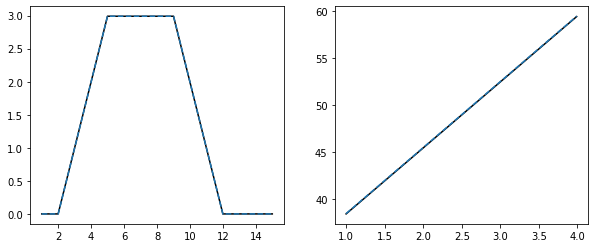

In [9]:
t0 = np.arange(1.0,4.0,0.01)
t = np.arange(1.0,15.0,0.01)
x = 1.0
y = 8.0
It = np.zeros((len(t),len(t0)))
Itint = np.zeros(len(t))
It0int =  np.zeros(len(t0))
Jt = np.zeros(len(t))
Lt =  np.zeros(len(t0))
for (i,th) in enumerate(t):
    for (j,t0h) in enumerate(t0):
        It[i,j] = I(th,t0h,x,y)
    Itint[i] = np.trapz(It[i,:],t0)
    Jt[i] = J(th,x,y,np.min(t0),np.max(t0))
for (j,t0h) in enumerate(t0):
    It0int[j] = np.trapz(t*It[:,j],t)
    Lt[j] = L(t0h+x,t0h+y,np.min(t),np.max(t))
Jtint = np.trapz(Jt,t)
Mt = M(x,y,np.min(t0),np.max(t0),np.min(t),np.max(t))
Kt = K(x,y,np.min(t),np.max(t))
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(t,Itint,c='k')
ax[0].plot(t,Jt,'--')
ax[1].plot(t0,It0int,c='k')
ax[1].plot(t0,Lt,'--')
print(Jtint,Mt)


Test 1: window 1 and window 2 positive

0.5221539855072463 0.5243868885869566


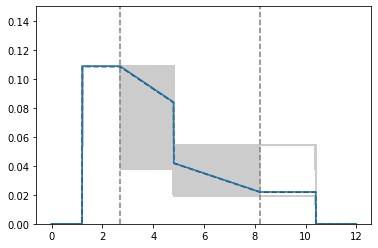

In [10]:
t = np.arange(0,12,0.01)
te = 1.2
tp = 2.7
ts = 4.8
taud = 0
tr = 10.4
tauisol = 10.0
taup = 5.5
Psisol = 0.5
tauf = 6
sens = 0.65
t0 = np.arange(tp,tp+tauf,0.01)
fh = np.zeros((len(t0),len(t)))
fhint = np.zeros(len(t))
gh = g(t,tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol)
for (j,t0h) in enumerate(t0):
    fh[j,:] = f(t,t0h,tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol)
for (i, th) in enumerate(t):
    fhint[i] = np.trapz(fh[:,i],t0)/tauf
plt.plot(t,np.transpose(fh),c=[0.8,0.8,0.8])
plt.plot([tp,tp],[0,1],'--',c=[0.5,0.5,0.5])
plt.plot([tp+taup,tp+taup],[0,1],'--',c=[0.5,0.5,0.5])
plt.plot(t,fhint,'--',c='k')
plt.plot(t,gh)
plt.ylim((0,0.15))
print(np.trapz(gh,t),F(tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol))

No window 1

(0, 0.2)

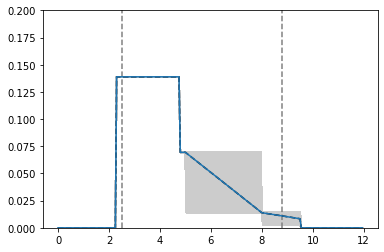

In [11]:
t = np.arange(0,12,0.05)
te = 2.3
tp = 2.5
ts = 4.8
taud = 2.5
tr = 9.5
tauisol = 10.0
taup = 6.3
Psisol = 0.5
tauf = 3
sens = 0.8
t0 = np.arange(tp,tp+tauf,0.001)
fh = np.zeros((len(t0),len(t)))
fhint = np.zeros(len(t))
gh = g(t,tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol)
for (j,t0h) in enumerate(t0):
    fh[j,:] = f(t,t0h,tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol)
for (i, th) in enumerate(t):
    fhint[i] = np.trapz(fh[:,i],t0)/tauf
plt.plot(t,np.transpose(fh),c=[0.8,0.8,0.8])
plt.plot([tp,tp],[0,1],'--',c=[0.5,0.5,0.5])
plt.plot([tp+taup,tp+taup],[0,1],'--',c=[0.5,0.5,0.5])
plt.plot(t,fhint,'--',c='k')
plt.plot(t,gh)
plt.ylim((0,0.2))

No window 2

(0, 0.2)

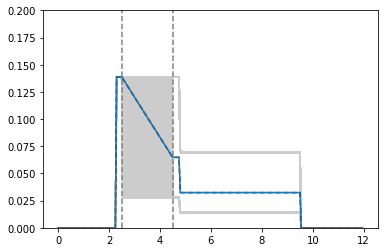

In [12]:
t = np.arange(0,12,0.05)
te = 2.3
tp = 2.5
ts = 4.8
taud = 0
tr = 9.5
tauisol = 10.0
taup = 2.0
Psisol = 0.5
tauf = 3
sens = 0.8
t0 = np.arange(tp,tp+tauf,0.001)
fh = np.zeros((len(t0),len(t)))
fhint = np.zeros(len(t))
gh = g(t,tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol)
for (j,t0h) in enumerate(t0):
    fh[j,:] = f(t,t0h,tp,ts,taup,taud,tauf,te,tr,sens,tauisol,Psisol)
for (i, th) in enumerate(t):
    fhint[i] = np.trapz(fh[:,i],t0)/tauf
plt.plot(t,np.transpose(fh),c=[0.8,0.8,0.8])
plt.plot([tp,tp],[0,1],'--',c=[0.5,0.5,0.5])
plt.plot([tp+taup,tp+taup],[0,1],'--',c=[0.5,0.5,0.5])
plt.plot(t,fhint,'--',c='k')
plt.plot(t,gh)
plt.ylim((0,0.2))

(0, 1.0)

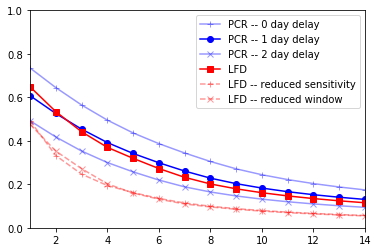

In [18]:
te = 1.2
Ttype = ['PCR -- 0 day delay','PCR -- 1 day delay','PCR -- 2 day delay',\
         'LFD','LFD -- reduced sensitivity', 'LFD -- reduced window']
Colors = [[0,0,1,0.4],[0,0,1,1],[0,0,1,0.4],[1,0,0,1],[1,0,0,0.4],[1,0,0,0.4]]
Style = ['-+','-o','-x','-s','--+','--x']
tp = [2.3,2.3,2.3,2.7,2.7,4.075]
dts = 0.1
taud = [0,1,2,0,0,0]
tr = 10.4
tauisol = 10.0
taup = [10.6,10.6,10.6,5.5,5.5,2.75]
Psisol = 0.5
tauf = np.arange(1,15)
sens = [0.8,0.8,0.8,0.65,0.325,0.65]
Fbaseline = Gapprox(tp[0],taup[0],taud[0],tauf[0],te,tr,0,tauisol,Psisol,0.1)
Ftest = np.zeros((len(Ttype),len(tauf)))
for i in np.arange(len(Ttype)):
    for j in np.arange(len(tauf)):
        Ftest[i,j] = Gapprox(tp[i],taup[i],taud[i],tauf[j],te,tr,sens[i],tauisol,Psisol,dts)
    plt.plot(tauf, 1-Ftest[i,:]/Fbaseline,Style[i],c=Colors[i],label=Ttype[i])
plt.legend()
plt.xlim(1,14)
plt.ylim(0,1.0)

In [19]:
t = np.arange(0,12,0.01)
g_baseline = g(t,tp[0],4.84,taup[0],taud[0],tauf[0],te,tr,0,tauisol,Psisol)
g_check = np.zeros((len(Ttype),len(t)))
for i in np.arange(len(Ttype)):
    g_check[i,:] = g(t,tp[i],4.84,taup[i],taud[i],tauf[2],te,tr,sens[i],tauisol,Psisol)
Lstyle = ['--','-',':','-','--',':']

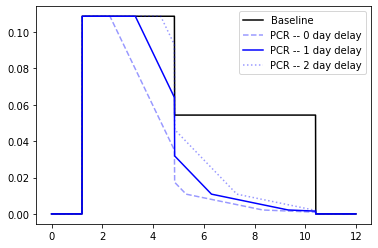

In [20]:
plt.plot(t,g_baseline,c='k',label='Baseline')
for i in [0,1,2]:
    plt.plot(t,g_check[i,:],Lstyle[i],c=Colors[i],label=Ttype[i])
plt.legend()

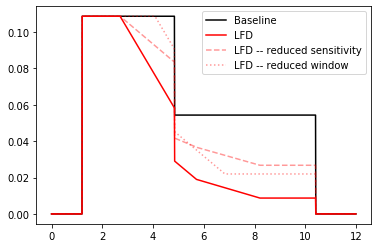

In [21]:
plt.plot(t,g_baseline,c='k',label='Baseline')
for i in [3,4,5]:
    plt.plot(t,g_check[i,:],Lstyle[i],c=Colors[i],label=Ttype[i])
plt.legend()

(0, 1.0)

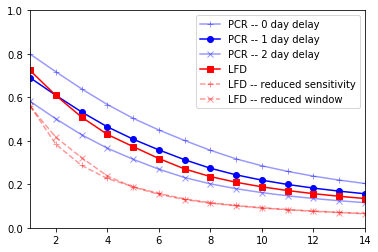

In [22]:
te = 1.2
Ttype = ['PCR -- 0 day delay','PCR -- 1 day delay','PCR -- 2 day delay',\
         'LFD','LFD -- reduced sensitivity', 'LFD -- reduced window']
Colors = [[0,0,1,0.4],[0,0,1,1],[0,0,1,0.4],[1,0,0,1],[1,0,0,0.4],[1,0,0,0.4]]
Style = ['-+','-o','-x','-s','--+','--x']
tp = [2.3,2.3,2.3,2.7,2.7,4.075]
dts = 0.1
taud = [0,1,2,0,0,0]
tr = 10.4
tauisol = 10.0
taup = [10.6,10.6,10.6,5.5,5.5,2.75]
Psisol = 0.0
tauf = np.arange(1,15)
sens = [0.8,0.8,0.8,0.65,0.325,0.65]
t = np.arange(0,12,0.01)
Fbaseline = Gapprox(tp[0],taup[0],taud[0],tauf[0],te,tr,0,tauisol,Psisol,dts)
Ftest = np.zeros((len(Ttype),len(tauf)))
Gcheck = np.zeros((len(Ttype),len(tauf),len(t)))
for i in np.arange(len(Ttype)):
    for j in np.arange(len(tauf)):
        Ftest[i,j] = Gapprox(tp[i],taup[i],taud[i],tauf[j],te,tr,sens[i],tauisol,Psisol,dts)
    plt.plot(tauf, 1-Ftest[i,:]/Fbaseline,Style[i],c=Colors[i],label=Ttype[i])
plt.legend()
plt.xlim(1,14)
plt.ylim(0,1.0)

In [23]:
t = np.arange(0,12,0.01)
g_baseline = g(t,tp[0],4.84,taup[0],taud[0],tauf[0],te,tr,0,tauisol,Psisol)
g_check = np.zeros((len(Ttype),len(t)))
for i in np.arange(len(Ttype)):
    g_check[i,:] = g(t,tp[i],4.84,taup[i],taud[i],tauf[2],te,tr,sens[i],tauisol,Psisol)
Lstyle = ['--','-',':','-','--',':']

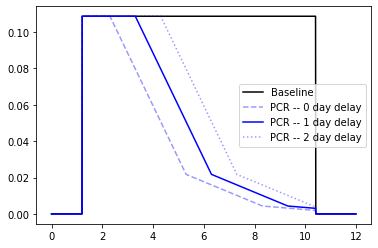

In [24]:
plt.plot(t,g_baseline,c='k',label='Baseline')
for i in [0,1,2]:
    plt.plot(t,g_check[i,:],Lstyle[i],c=Colors[i],label=Ttype[i])
plt.legend()

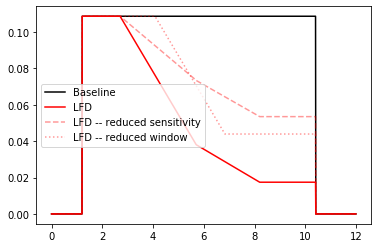

In [25]:
plt.plot(t,g_baseline,c='k',label='Baseline')
for i in [3,4,5]:
    plt.plot(t,g_check[i,:],Lstyle[i],c=Colors[i],label=Ttype[i])
plt.legend()